# ZAIRA

As this wave from memories flows in, the city soaks it up like a sponge and expands. A description of Zaira as it is today should contain all Zaira’s past. The city, however, does not tell its past, but contains it like the lines of a hand, written in the corners of the streets, the gratings of the windows, the banisters of the steps, the antennae of the lightning rods, the poles of the flags, every segment marked in turn with scratches, indentations, scrolls.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

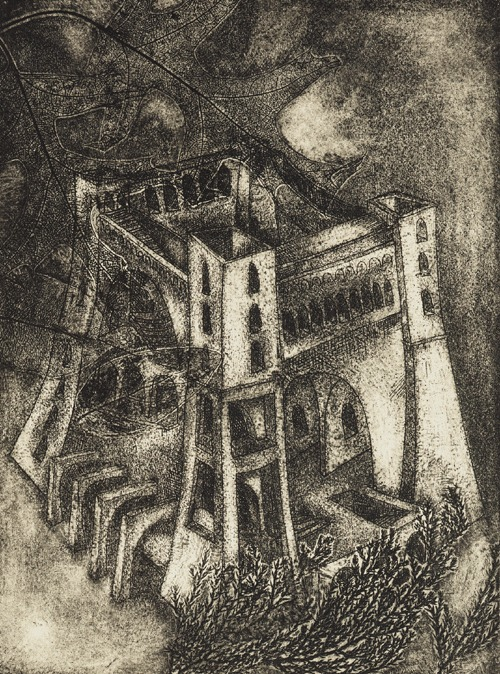

In [3]:
Image(filename='../../Images/zaira.jpg') 

### ZAIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)

        2. Simulates the response of the TRACKING plane (add gaussian and dark current noise), and produces SiPM RWF and store in output h5 file.
            
        3. Produces the SiPM calibration parameters

        4. Monitor the input SiPM MCRD and output SiPM RFW. 
        
author: Jose A. Hernando
version: v0_00 

### Revision

In [4]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

13/10/2016   18:35:06


### Dependencies

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import tables
import pandas as pd
import time
import cProfile

In [7]:
import logging
import sys
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [9]:
pp = %env PYTHONPATH
print(pp)
from Util import *
from Configure import *
from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### Inspecting the input file  

In [13]:
# input histograms 

Initializing NoiseSampler... OK


In [30]:
afe = np.array([[0.1,0.4],]*5)
print(afe)
print(afe[:,0])
azeros = np.zeros(5)
agaus = afe[:,0]
ar = np.array(map(lambda i: np.random.normal(*afe[i,:],size=3),np.arange(5)))
print(ar)

[[ 0.1  0.4]
 [ 0.1  0.4]
 [ 0.1  0.4]
 [ 0.1  0.4]
 [ 0.1  0.4]]
[ 0.1  0.1  0.1  0.1  0.1]
[[-0.03614005 -0.19757797 -0.5196246 ]
 [-0.33124593  0.42964624 -0.19186771]
 [ 0.26769002  0.25741607  0.65746739]
 [ 0.22568692  0.38281702 -0.20054869]
 [-0.47475097  0.41673984  0.54376591]]


In [63]:
#from scipy.stats import norm,poisson
class FEE_SiPMs:
    """ Front End SiPMs electronic simulations: gaussian noise and Dark Current
        1) noise and dark current rate are uploaded from a txt file
        2) noise is produced per SiPMs
    """
    
    def __init__(self,filename,index_map,nsamples=1200):
        """ Create a FE for SiPMs.
        nsipms: number of sipms (1792)
        nsamples: number of time samples (1200)
        tsame: integral time of each sample (1.=1 us)
        fname: file name with the data of the SiPMs noise.
            rows of sensorID, noise (in pes), and dark current rate in (us)
        """
        # tsample units is us!
        fi = open(filename)
        print('Loading DB FE SiPMS file {} ...'.format(filename))
        lines = fi.readlines()
        nsipms = len(index_map)
        # while the total SiPMs are not calibrated use the average:
        self.indexes = []
        self._fe = [(0,0)]*nsipms
        for i,line in enumerate(lines[1:]):
            words = line.split()
            if (len(words)!=3): print('words {}'.format(words))
            sensorid,gaus,dark = int(words[0]),float(words[1]),float(words[2])
            index = index_map[sensorid]
            self._fe[index] = (gaus,dark)
#           print(' i {} id {} idx {} nois {} dark {} '.format(i,sensorid,index,gaus,dark))
            self.indexes.append(index)
        fi.close()
        print('Loaded  DB FE SiPMs, number of SiPMs in DB {}'.format(len(self.indexes)))
        #print(' fe {} '.format(self.fe))
        self.nsipms = nsipms
        self.nsamples = nsamples
        self._fe = np.array(self._fe)
        self.indexes = np.array(self.indexes)
        return
  

    def Sample(self):
        """ Returns the array with the noise for all SiPMs with nshapes!
        """
        def _sample(index):
            gaus,dark = self._fe[index]
            ag = np.random.normal(0.,gaus,size=self.nsamples)
            ap = np.random.poisson(dark,size=self.nsamples)
            return ag+ap
        sam = np.array(map(_sample,self.indexes))
        return sam

In [64]:
sipmfee = FEE_SiPMs(filename='../../Database/DB_FESiPMs_161006.txt',
                        index_map=sipms_index_map,nsamples=100*nsamples)

Loading DB FE SiPMS file ../../Database/DB_FESiPMs_161006.txt ...
Loaded  DB FE SiPMs, number of SiPMs in DB 1705


In [65]:
# generate n-events SiPMs only noise
sipmnois = sipmfee.Sample()

In [66]:
# methods to plot SiPM data

from matplotlib.mlab import griddata

def polo_qids(qids):
    """ plots charges
    1) total charge vs ID
    2) total charge distribution
    """
    plt.subplots(2,1)
    plt.subplot(2,1,1)
    plt.plot(qids)
    plt.subplot(2,1,2)
    plt.hist(qids,bins=100,log=True)
    plt.show()
    return
    
def polo_wfs(wfs,ylog=False):
    """ plots the wfs
    """
    nx = len(wfs)
    ny = 2
    plt.subplots(nx,2,figsize=(ny*4,nx*3))
    for i,wf in enumerate(wfs):
        plt.subplot(nx,ny,2*i+1)
        plt.plot(wf)
        plt.subplot(nx,ny,2*i+2)
        plt.hist(wf,100,log=ylog)
    plt.show()
    return
    
def polo_indwfs(indwfs):
    """ plots indexed wfs 
    """
    ### list of colors to display
    colors = plt.cm.Set3(np.linspace(0., 1., len(ids)))

    ### display the indexed w.fs
    for i,indwf in enumerate(indwfs):
        xs = map(lambda x: x[0],indwf)
        ys = map(lambda x: x[1],indwf)
        plt.plot(xs,ys,color=colors[i])
    plt.show()
    return

def polo_qslices(qslices):
    xs = map(lambda x:x[0],qslices)
    ys = map(lambda x:x[1],qslices)
    plt.plot(xs,ys)
    return       

def polo_xyq(vals,show=False):
    """ plots the x,y,q contour from the list (vals) of [(x,y,q),] items
    """
    xs = map(lambda i: vals[i][0],range(nsipms))
    ys = map(lambda i: vals[i][1],range(nsipms))
    zs = map(lambda i: vals[i][2],range(nsipms))
    xmin,xmax = min(xs),max(xs)
    #print('xmin {} xmax {}'.format(xmin,xmax))
    n = int(xmax-xmin)
    xi = np.linspace(xmin-0.5,xmax+0.5,n)
    yi = np.linspace(xmin-0.5,xmax+0.5,n)

    zi = griddata(xs, ys, zs, xi, yi,interp='linear')
    plt.contourf(xi, yi, zi)
    plt.colorbar()
    if (show): plt.show()
    return

def polo_xyq_slices(valslices):
    """ plots the x,y,q contour plot of several slices. 
    Each slice is a list of [(x,y,q),] items 
    """
    n = len(valslices)
    nx = int(sqrt(n))
    ny=nx
    while(nx*ny<n):ny=ny+1
    plt.subplots(nx,ny,figsize=(4*ny,3*nx))
    for i,vals in enumerate(valslices):
        plt.subplot(nx,ny,i+1)
        polo_xyq(vals)
    plt.show()
    

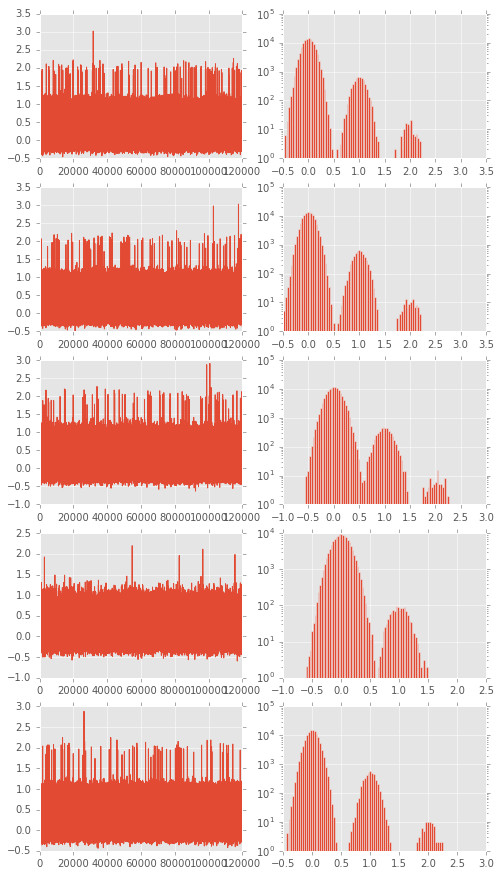

In [67]:
polo_wfs(sipmnois[4:9],ylog=True)

In [68]:
def fun_offset(wf,d=0.5):
    def fun(x0):
        ax0 = np.ones(wf.ndim)*x0
        y = wf-ax0
        y2 = y*y
        return y2.sum()
    return fun  

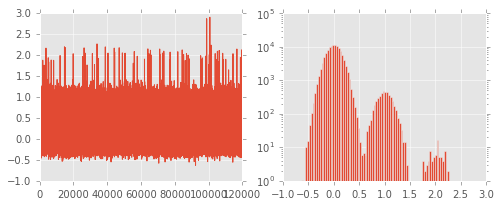

     fun: 7115.8889324601823
 message: 'Solution found.'
    nfev: 6
  status: 0
 success: True
       x: 0.039372794432239511


In [69]:
from scipy.optimize import minimize_scalar

wf = sipmnois[6]
polo_wfs([wf,],ylog=True)

fun = fun_offset(wf)
map(fun,range(5))
result = minimize_scalar(fun,bounds=[-5.,5.],method='Bounded')
print(result)

In [123]:
#fun = fun_period(wf)
def fun_mperiod(wf):
    def fun(pe):
        ks = map(lambda x: int((x+0.5*pe)/pe),wf)
        vals = zip(ks,wf)
        xvals = filter(lambda z: z[0]>0,vals)
        df = map(lambda z: (z[1]-z[0]*pe)/pe,xvals)
        df2 = map(lambda x:x*x,df)
        dd = sum(df2)/(1.*len(df2))
        rms = sqrt(dd)
        return rms
    return fun

#fun = fun_period(wf)
def fun_aperiod(wf):
    def fun(pe):
        ape = np.ones(wf.ndim)*pe
        ks = (wf+0.5*ape)/ape
        ks = np.array(map(int,ks))
        vals = np.array(zip(ks,wf))
        xvals = np.array(filter(lambda z: z[0]>0,vals))
        xxs = xvals[:,1]
        x0s = xvals[:,0]
        df = (xxs-x0s*pe)/pe
        #df = np.array(map(lambda z: (z[1]-z[0]*pe)/pe,xvals))
        df2 = df*df
        dd = df2.sum()
        nx = len(df2)
        rms = sqrt(dd/nx)
        return rms
    return fun

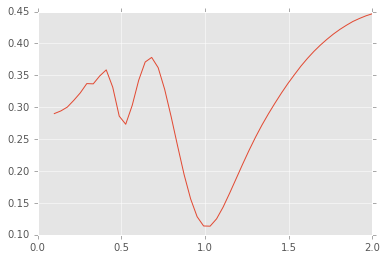

In [124]:
wf = sipmnois[4]
fun = fun_mperiod(wf)
fun(0.5),fun(1.),fun(2.)
pes = np.linspace(0.1,2.,50)
#ys = map(fun,pes)
#plt.plot(pes,ys)
fun = fun_aperiod(wf)
ys2 = map(fun,pes)
plt.plot(pes,ys2)

In [125]:
fun = fun_aperiod(wf)
result = minimize_scalar(fun,bounds=[0.2,2.],method='Bounded')
print(result)

     fun: 0.11187636960560442
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 1.0117874566160365


val  1.00894865824
val  1.01273894928
val  1.00843288335
val  1.00364403305
val  1.01178566579
val  1.01387173857
val  1.02148663952
val  1.05013555681
val  1.00945221849
val  1.01107446785
val  1.01102918632
val  1.01011511684
val  1.04023237286
val  1.04214297688
val  1.0281297849
val  1.01459170095
val  1.00939097064
val  1.00961377113
val  1.00829262212
val  1.01016358074
val  1.00989297783
val  1.00949677983
val  1.01098964571
val  1.01264437092
val  1.00695443335
val  1.00370623399
val  1.00932476791
val  1.01111514343
val  1.01085434003
val  1.0155755174
val  1.0104596343
val  1.00787495411
val  1.0077774415
val  1.00883266666
val  1.00421883586
val  1.00531495895
val  1.00658899997
val  1.00971696177
val  1.01150290088
val  1.00535700124
val  1.01042060863
val  1.01080374319
val  1.01037869031
val  1.00674876928
val  1.00793130869
val  1.00755033164
val  1.00728740016
val  1.00896547707
val  1.01033101106
val  1.00986976263
val  1.00672671417
val  1.00519230486
val  1.006651203

(array([ 16.,  65.,  13.,   1.,   1.,   1.,   0.,   1.,   1.,   1.]),
 array([ 1.00175764,  1.00659543,  1.01143322,  1.01627101,  1.02110881,
         1.0259466 ,  1.03078439,  1.03562218,  1.04045997,  1.04529776,
         1.05013556]),
 <a list of 10 Patch objects>)

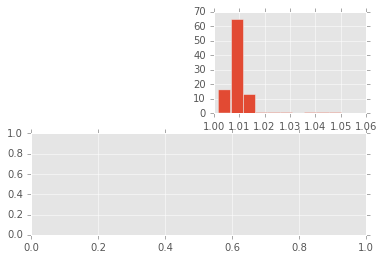

In [128]:
def fit_offset(wf):
    fun = fun_offset(wf)
    result = minimize_scalar(fun,0.8,bounds=[-3.,3.],method='Bounded')
    val = -1.
    if (result.success): val=result.x
    print('val ',val)
    return val

def fit_period(wf):
    fun = fun_aperiod(wf)
    result = minimize_scalar(fun,1.2,bounds=[0.2,3.],method='Bounded')
    val = -1.
    if (result.success): val=result.x
    print('val ',val)
    return val
    
xs = map(fit_period,sipmnois[:100])
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.plot(xs)
plt.subplot(2,2,2)
plt.hist(xs,100)

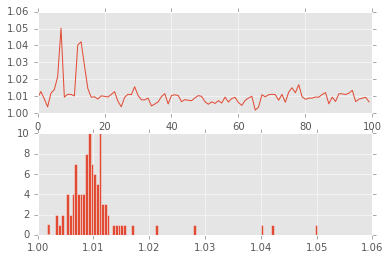

In [130]:
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.plot(xs)
plt.subplot(2,1,2)
c = plt.hist(xs,100)

In [206]:
sipmfee_led = FEE_SiPMs(filename='../../Database/DB_FESiPMs_161006.txt',
                        index_map=sipms_index_map,nsamples=100*nsamples)
mu = 0.13
for index in sipmfee_led.indexes: sipmfee_led._fe[index][1] +=mu
sipmfee_led._fe[0]

Loading DB FE SiPMS file ../../Database/DB_FESiPMs_161006.txt ...
Loaded  DB FE SiPMs, number of SiPMs in DB 1705


array([ 0.10446  ,  0.1557535])

In [207]:
sipmled = sipmfee_led.Sample()

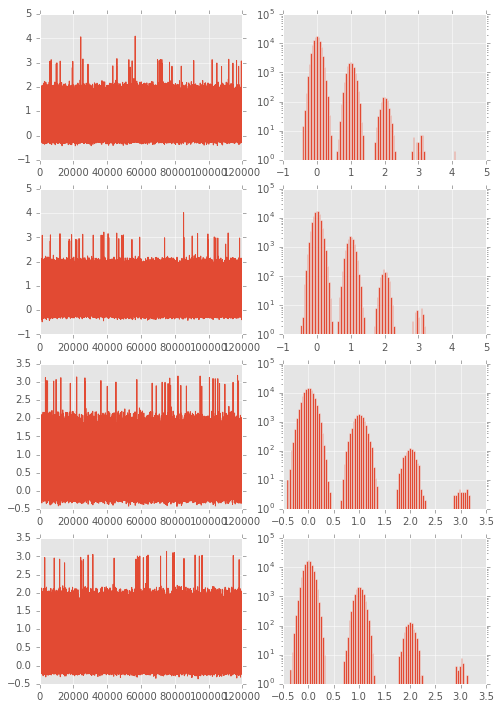

In [208]:
polo_wfs(sipmsled[0:4],ylog=True)

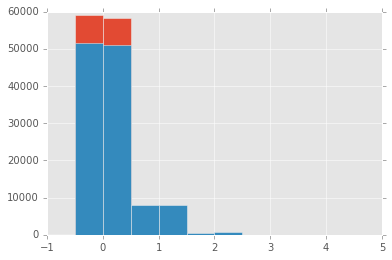

In [209]:
index = 2

nois = plt.hist(sipmnois[index],bins=12,range=(-1.,5.))
led = plt.hist(sipmled[index],bins=12,range=(-1.,5.))

[  0.00000000e+00   5.90490000e+04   5.82170000e+04   1.38400000e+03
   1.33000000e+03   1.20000000e+01   8.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[-1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]
0.875171467764
 mu visible  1.08428759158
 f visible  0.124828532236
 mu hat  0.133335448664


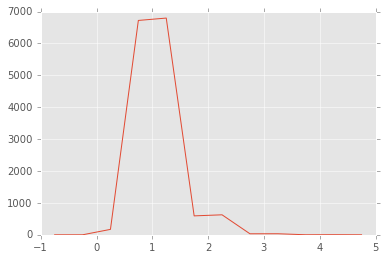

In [210]:
ynois,xs = nois[0],nois[1]
print(ynois)
print(xs)
yled = led[0]
frat = yled[1]/ynois[1]
print(frat)
ynois2 = frat*ynois
sig = yled-ynois2
xcs = 0.5*(xs[1:]+xs[:-1])
muv = sum(xcs*sig)/sum(sig)
fvis = sum(sig)/sum(yled)
muhat = -1.*(log(1-fvis))
print(' mu visible ',muv)
print(' f visible ',fvis)
print(' mu hat ',muhat)
plt.plot(0.5*(xs[1:]+xs[:-1]),sig)

In [211]:
cons,xs = np.histogram(sipmled[0],bins=12,range=(-1.,5.))
print(cons)
print(xs)

[    0 51324 51388  8082  7898   596   646    28    34     3     1     0]
[-1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]


mu ave 0.130045810763


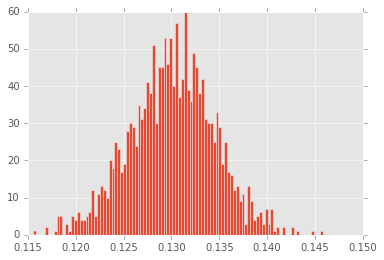

In [212]:
def muhat(wfnois,wfled,bins=12,range=(-1.,5.)):
    ynois,xs = np.histogram(wfnois,bins=bins,range=range)
    yled,xs = np.histogram(wfled,bins=bins,range=range)
    #print(' ynois ',ynois)
    #print(' y led',yled)
    frat = (1.*yled[1])/(1.*ynois[1])
    #print(' f rat ',frat)
    ynois2 = frat*ynois
    sig = yled-ynois2
    fvis = (1.*sum(sig))/(1.*sum(yled))
    if (fvis>=1.): return -1.
    muhat = -1.*(log(1.-fvis))
    return muhat

mus = map(lambda i: muhat(sipmnois[i],sipmled[i]),range(len(sipmled)))
#print(mus)
cs = plt.hist(mus,100)
print('mu ave',sum(mus)/(1.*len(mus)))

That's all folks!